In [22]:
# https://youtu.be/XyX5HNuv-xE
# https://youtu.be/q-p8v1Bxvac
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers. 
"""
import os
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.utils import normalize

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

################################################################
def multi_unet_model(n_classes=5, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [2]:
# resizes images to desired dimensions
def resize(img, height=256, width=256):
    return cv2.resize(img, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

In [3]:
def get_images(jsrt_path='Downloads', height=256, width=256, original_size=False):
    if original_size:
        height = 1024
        width = 1024
    
    # path to raw images
    home = os.path.expanduser('~')
    image_dir = os.path.join(home, jsrt_path, 'jsrt/images/images')
    
    # get image names
    image_names = os.listdir(image_dir)
    image_names.sort()
    
    # create numpy array to hold image arrays
    images = np.zeros((len(image_names), height, width, 1))
    
    # load iamges
    for i in range(len(image_names)):
        img_path = os.path.join(image_dir, image_names[i])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # resize
        img = resize(img, height, width)
        img = np.expand_dims(img, axis=2)
        
        # normalize
        img = normalize(img, axis=1)
        
        images[i] = img
    
    return images

In [4]:
# loads grouped image masks
def load_masks(masks_pickle='masks.pickle', dir_path=os.path.join(os.path.expanduser('~'),'Downloads/data')):
    f = open(os.path.join(dir_path, masks_pickle), 'rb')
    masks = pickle.load(f)
    
    return masks

In [5]:
images = get_images()

In [6]:
masks = load_masks()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.1, random_state=9)

In [46]:
model = multi_unet_model()

In [47]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
history = model.fit(x_train, y_train,
          batch_size=4,
          epochs=10,
          validation_data=(x_test, y_test),
          shuffle=False)

Epoch 1/10
56/56 [==============================] - 6s 65ms/step - loss: 0.5738 - accuracy: 0.2377 - val_loss: 0.3248 - val_accuracy: 0.1763
Epoch 2/10
56/56 [==============================] - 3s 59ms/step - loss: 0.2325 - accuracy: 0.1997 - val_loss: 0.2385 - val_accuracy: 0.1890
Epoch 3/10
56/56 [==============================] - 3s 59ms/step - loss: 0.1933 - accuracy: 0.3292 - val_loss: 0.1737 - val_accuracy: 0.5322
Epoch 4/10
56/56 [==============================] - 3s 59ms/step - loss: 0.1282 - accuracy: 0.4791 - val_loss: 0.1419 - val_accuracy: 0.5129
Epoch 5/10
56/56 [==============================] - 3s 59ms/step - loss: 0.0932 - accuracy: 0.4925 - val_loss: 0.1174 - val_accuracy: 0.4685
Epoch 6/10
56/56 [==============================] - 3s 59ms/step - loss: 0.0718 - accuracy: 0.4785 - val_loss: 0.0755 - val_accuracy: 0.4328
Epoch 7/10
56/56 [==============================] - 3s 59ms/step - loss: 0.0588 - accuracy: 0.4822 - val_loss: 0.0519 - val_accuracy: 0.4807
Epoch 8/10
56

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

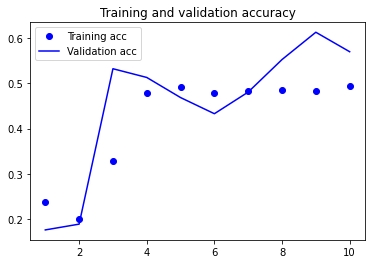

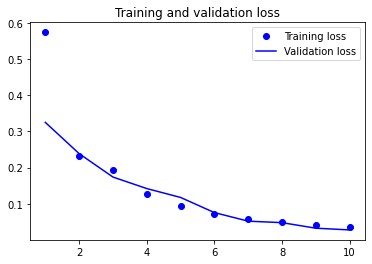

In [50]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [54]:
test = np.array([images[77]])

In [55]:
test.shape

(1, 256, 256, 1)

In [56]:
t = model.predict(test)

In [57]:
t.shape

(1, 256, 256, 5)

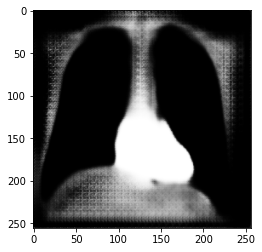

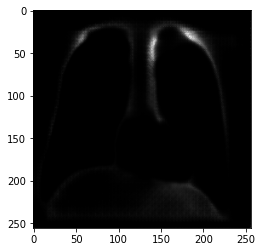

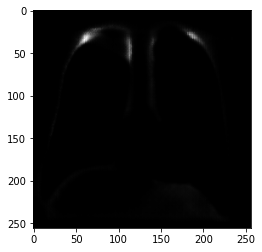

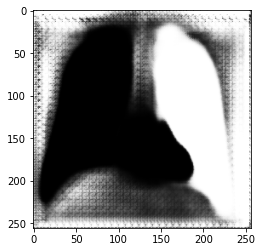

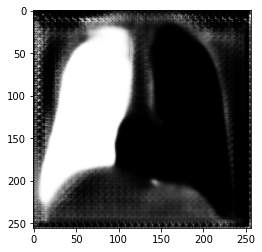

In [58]:
for i in range(5):
    plt.imshow(t[0][:,:,i], cmap='gray')
    plt.show()